# Resiliency tool

In [1]:
import resiliencyTool as rt
import pandas as pd
import numpy as np
from datetime import date as dt_date

import warnings
warnings.simplefilter("ignore") # warning are ignored for now


## Network initialization

In [2]:
simulationName = 'basic_example';
network = rt.network.Network(simulationName);

#### Fragility Curves are automatically generated once the network object is created

### Plot a specific fragility curve:

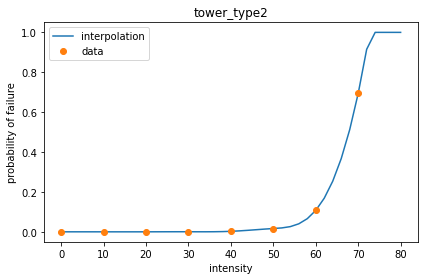

In [3]:
xnew = xnew = np.linspace(0, 80, num=41, endpoint=True)
fig, ax = network.fragilityCurves['tower_type2'].plot_fc(xnew, k=3)

### Or Plot all the fragility curves in the database

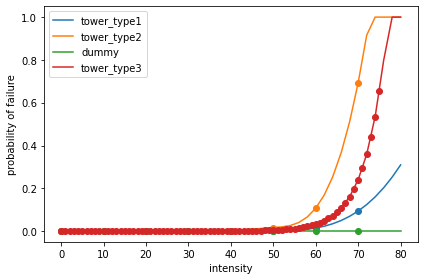

In [4]:
fig, ax = rt.fragilitycurve.plotFragilityCurves(network.fragilityCurves, xnew, k=3)

### Method 1: Generate a hazard element by reading a .nc file

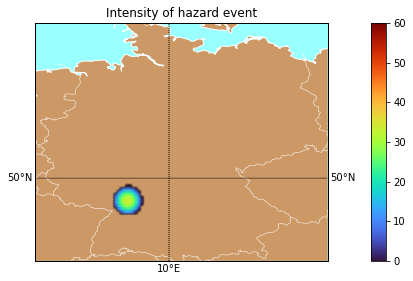

In [5]:
network.event.hazardFromNC(simulationName, 'sythetic_data.nc')
fig, ax = network.event.plot(10, projection='cyl', edge_pad=0)

In [6]:
network.event.plot_gif(simulationName, 'sythetic_data.gif', speed=3, projection='cyl', edge_pad=0)

![method1](file/input/basic_example/hazards/gif/sythetic_data.gif "method1")

### Method 2: Generate a hazard element by reading a trajectory csv file

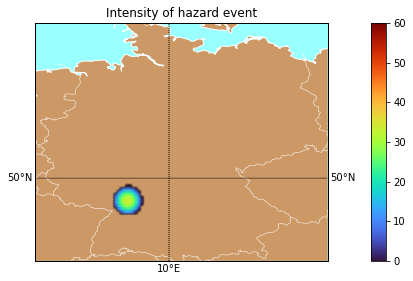

In [6]:
network.event.hazardFromTrajectory(simulationName, 'trajectory.csv', 
                                   max_intensity=60., max_radius=50., 
                                   sdate = dt_date(2022,4,1), edate = dt_date(2022,4,3), 
                                   geodata1 = rt.network.GeoData(47.4,5.8), geodata2 = rt.network.GeoData(54.9,15.0),
                                   delta_km=10, frequency='1H')

fig, ax = network.event.plot(10, projection='cyl', edge_pad=0)

In [7]:
network.event.plot_gif(simulationName, 'trajectory.gif', speed=3, projection='cyl', edge_pad=0)

![method2](file/input/basic_example/hazards/gif/trajectory.gif "method2")

### Method 3: Generate a static hazard element by providing the location of the epicenter

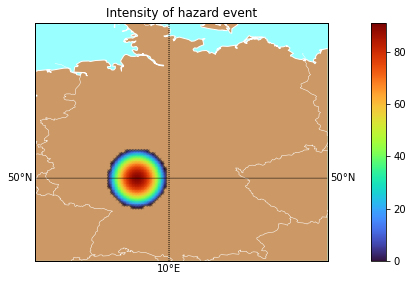

In [7]:
network.event.hazardFromStaticInput(simulationName, 'static_event.nc',
                                    max_intensity=90, max_radius=100,
                                    sdate = dt_date(2022,4,1), edate = dt_date(2022,4,3),
                                    geodata1 = rt.network.GeoData(47.4,5.8), geodata2 = rt.network.GeoData(54.9,15.0),
                                    delta_km=10,
                                    epicenter_lat=50, epicenter_lon=9,
                                    frequency='1H', epicenter_radius=1, epicenter_intensity=1)

fig, ax = network.event.plot(10, projection='cyl', edge_pad=0)

In [10]:
network.event.plot_gif(simulationName, 'static_event.gif', speed=3, projection='cyl', edge_pad=0)

![method3](file/input/basic_example/hazards/gif/static_event.gif "method3")